# План симуляций
0. Превышение критической энергии, условие  возникновения лавины.
1. Симуляции паратметров электронной лавины без учета гамма-квантов
2. Расчет длинны нарастания лавины для разных высот и полей (делая поправку для поля на высоту)
3. Расчет средней энергии электронов, спектра электронов, зависимости от начальной энергии




In [23]:
from dataclasses import dataclass
import numpy as np
import matplotlib.pyplot as plt
import tables
import matplotlib as mpl

In [47]:
path = "/home/zelenyy/data/thunderstorm/test/result.hdf5"
path = "/mnt/storage2/phd/data/thunderstorm/critical_energy/result.hdf5"

In [48]:
with tables.open_file(path) as h5file:
    # print(h5file)
    for group in h5file.root:
        table = h5file.get_node(group, "stacking_simple")
        print(repr(table.attrs))
        data = table.read()
        break

/sim0000/stacking_simple._v_attrs (AttributeSet), 32 attributes:
   [CLASS := 'TABLE',
    FIELD_0_FILL := 0,
    FIELD_0_NAME := 'event',
    FIELD_1_FILL := 0,
    FIELD_1_NAME := 'id',
    FIELD_2_FILL := 0,
    FIELD_2_NAME := 'parent_id',
    FIELD_3_FILL := 0,
    FIELD_3_NAME := 'particle',
    FIELD_4_FILL := 0.0,
    FIELD_4_NAME := 'energy',
    FIELD_5_FILL := 0.0,
    FIELD_5_NAME := 'theta',
    FIELD_6_FILL := 0.0,
    FIELD_6_NAME := 'radius',
    FIELD_7_FILL := 0.0,
    FIELD_7_NAME := 'z',
    FIELD_8_FILL := 0.0,
    FIELD_8_NAME := 'time',
    NROWS := 8,
    TITLE := '',
    VERSION := '2.7',
    path := 'sim0000',
    text := '/npm/geometry/type gdml\n/npm/geometry/gdml .././gdml/0.gdml\n/npm/thunderstorm/physics standard_opt_4\n/npm/thunderstorm/minimal_energy 0.10220286877494192 MeV\n/npm/thunderstorm/stacking/electron false\n/npm/thunderstorm/stacking/positron false\n/npm/thunderstorm/stacking/gamma false\n/npm/thunderstorm/stacking/save_gamma false\n/npm/thund

In [4]:
bins = np.arange(0.001, 2, 0.001)


In [70]:
@dataclass
class CEData:
    number : int
    energy : float
    hist : np.ndarray

def select_data(table, field, height):
    m_field = table.attrs["values_gdml_field"][0]
    m_height = table.attrs["values_gdml_height"][0]
    return np.isclose([m_field, m_height], [field, height]).all()

def get_data(path, field = 0.0, height = 0.0):
    result = []
    bins = np.arange(0.001, 2, 0.001)
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                hist, _ = np.histogram(data["energy"], bins=bins)
                result.append(CEData(number, energy, hist))
    return result, bins

In [60]:
ce_list, bins = get_data(path, field=9e-4)

In [61]:
ce_list = sorted(ce_list, key=lambda x: x.energy)

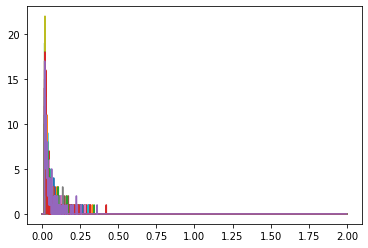

In [62]:
for item in ce_list:
    plt.step(bins[:-1], item.hist)

In [63]:
for item in ce_list:
    print((item.hist != 0).sum()/item.number, ce_list.index(item))

0.0 0
0.0 1
0.0 2
0.0 3
0.0 4
0.0 5
0.0 6
0.0 7
0.01 8
0.01 9
0.02 10
0.05 11
0.07 12
0.05 13
0.06 14
0.12 15
0.15 16
0.23 17
0.22 18
0.27 19
0.31 20
0.33 21
0.28 22
0.32 23
0.46 24
0.42 25
0.43 26
0.59 27
0.55 28
0.64 29
0.55 30
0.48 31
0.62 32
0.64 33
0.66 34
0.65 35
0.66 36
0.57 37
0.65 38
0.58 39
0.68 40
0.61 41
0.72 42
0.68 43
0.72 44
0.77 45
0.69 46
0.8 47
0.68 48
0.76 49
0.83 50
0.78 51
0.82 52
0.81 53
0.85 54


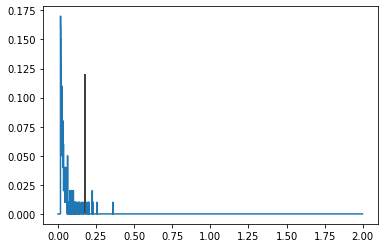

In [65]:
item = ce_list[-1]
n = 100
plt.step(bins[:-1], item.hist/item.number)
plt.vlines(item.energy, 0, 0.12)

In [67]:
def get_data_event(path, field = 0.0, height = 0.0):
    result = []
    with tables.open_file(path) as h5file:
        for group in h5file.root:
            table = h5file.get_node(group, "stacking_simple")
            if select_data(table, field, height):
                data = table.read()
                energy =  table.attrs["values_macros_energy"]
                number =  table.attrs["values_macros_number"]
                _, temp  = np.unique(data["event"], return_counts=True)
                result.append(CEData(number, energy, temp))
    return result

In [71]:
event_list = get_data_event(path, field=9e-4)

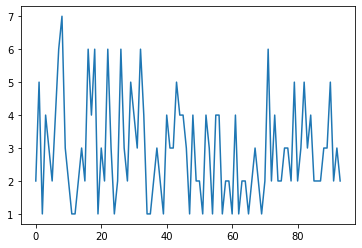

In [72]:
item = event_list[-1]
plt.plot(item.hist)